<div style="text-align: center;">
<img src="./src/img/portada.jpeg" alt="Descripción de la imagen" style="width: 900px; border-radius: 20px;">

 *Disclaimer*  
*Este proyecto de Machine Learning ha sido realizado en el marco de las actividades del bootcamp en Data Science de The Bridge, con fines exclusivamente educativos.*  
*La información contenida en este notebook, así como los análisis, resultados y conclusiones presentadas, no deben interpretarse como representativos de la realidad ni utilizados en contextos profesionales o de toma de decisiones reales.*  
    
  
---

# Proyecto de Ciencia de Datos

## <a name="índice"></a>Índice

1. [Entendimiento del problema y los datos](#capitulo1)
    - [Objetivo del proyecto](#objetivo)
    - [Tipo de problema (clasificación/regresión)](#tipo-problema)
    - [Carga y descripción inicial de los datos](#carga-datos)
    - [Distribución del target](#distribucion-target)
    - [División train/test](#division-train-test)

2. [Exploración y diagnóstico de calidad de datos](#capitulo2)
    - [Eliminación de variables irrelevantes](#eliminacion-irrelevantes)
    - [Análisis univariante y bivariante](#analisis-uni-bivariado)
    - [Duplicados](#duplicados)
    - [Missings](#missings)
    - [Outliers](#outliers)
    - [Anomalías y errores](#anomalías)

3. [Ingeniería de variables](#capitulo3)
    - [Transformaciones (log, binning...)](#transformaciones)
    - [Codificación (OneHot, Label)](#codificacion)
    - [Nuevas variables](#nuevas-variables)
    - [Escalado de variables](#escalado)

4. [Selección de modelo y validación](#capitulo4)
    - [Elección de métrica (según el problema)](#eleccion-metrica)
    - [Comparación de modelos candidatos](#comparacion-modelos)
    - [Tuning de hiperparámetros](#tuning)
    - [Validación cruzada](#validacion-cruzada)

5. [Resultados y conclusiones](#capitulo5)
    - [Evaluación final en test](#evaluacion-final)
    - [Principales insights](#insights)
    - [Limitaciones y posibles mejoras](#limitaciones)
    - [Preparación para producción](#produccion)

---

## <a name="capitulo1"></a>**1. Entendimiento del problema y los datos**

En esta sección se presenta el problema que se desea resolver, el tipo de tarea de aprendizaje automático a aplicar y una primera toma de contacto con los datos.



### <a name="objetivo"></a>**Objetivo del proyecto**
[↑ Volver al índice](#índice)

Finalmente hemos planteado un doble objetivo,

1. **Predicción de precios de adjudicación** en base a parámetros como tipo de contrato, importe base, entidad adjudicadora, entre otros.

Ante los recientes informes publicados por la UCO, negocio se plantea la necesidad de herramientas analíticas que permitan detectar posibles anomalías en los precios adjudicados, fijando un segundo objetivo:

2. **Contraste entre precios esperados y reales** para identificar posibles desviaciones que pudieran sugerir trato de favor o sobrecostes injustificados, con algunas de las adjudicaciones publicadas en el informe 96/2025 de 5 de junio de 2025 emitido por la Unidad Central Operativa.

Para su desarrollo se han utilizando los datos abiertos publicados por el Ministerio de Hacienda (https://www.hacienda.gob.es/es-ES/GobiernoAbierto/Datos%20Abiertos/Paginas/licitaciones_plataforma_contratacion.aspx). El modelo se entrenará con un dataset que incluye licitaciones (excluyendo contratos menores) desde **2012 hasta julio de 2025**, extraído de la plataforma pública de contratación del Estado: https://contrataciondelestado.es.

Cabe destacar que no todas las administraciones públicas alojan sus licitaciones en la plataforma mencionada, por lo que algunos casos relevantes podrían quedar fuera del análisis. Aun así, se espera que el modelo proporcione una herramienta útil para mejorar la transparencia y el control en los procesos de contratación pública.

<table style="border: none;">
<tr style="border: none;">
<td style="width: 45%; border: none;">

<!-- Imagen aquí -->
<img src="./src/img/ml_types.png" alt="Imagen representativa" style="width: 100%; border-radius: 10px;"/>

</td>
<td style="width: 55%; vertical-align: top; border: none;">

<h3><b>Tipo de problema: regresión</b></h3>

<p>
Este proyecto tiene como objetivo abordar un problema de <strong>regresión</strong>, en el cual se busca predecir una variable numérica continua a partir de distintas variables predictoras.
</p>

<p>
Se aplicarán técnicas de exploración de datos, ingeniería de variables y modelos de aprendizaje supervisado para estimar con precisión la variable objetivo. A lo largo del desarrollo se pondrán en práctica herramientas comunes en un flujo de trabajo de <em>machine learning</em>, enfocadas en la interpretación y validación rigurosa de los modelos entrenados.
</p>

</td>
</tr>
</table>

### <a name="carga-datos"></a>**Carga y descripción inicial de los datos**

#### **Preparación del modelo**
[↑ Volver al índice](#índice)

Para el desarrollo de este Proyecto se han realizado una serie de pasos que se irán detallando a continuación.
Lo primero que haremos será la <u>**carga datos**</u> una vez descargados los archivos .zip desde el Ministerior de Hacienda.

*Nota: durante el ejercicio nos hemos visto obligados con ayuda de nuestro asistente favorito a crear un pequeño script que nos ha permitido, descomprimir los archivos .zip ubicados en una carpeta, transformar y consolidar los archivos .atom a .csv. Para mayor información consulta en la carpeta ./utils/ el archivo mytb_placsp.py que hemos necesitado pues transformar manualmente más de 6.000 archivos era una auténtica locura*

In [127]:
# Tengo curiosidad por controlar el tiempo de ejecución del notebook
import time
start_time = time.time()

In [128]:
# Importamos las librerias a utilizar en el desarrollo del proyecto
import sys
sys.path.append("./src/utils")

import matplotlib.pyplot as plt
import mytb_placsp as plac   # Importamos uno de los módulos generados específicamente para este proyecto. Aunque no lo utilizaré por el elevado tiempo que lleva su carga.
import mytb                  # Importamos el segundo de los módulo con utildades desarrolladas por el alumno
import mytrans               # Importamos el tercer de los módulos con utilidades desarrolladas por el alumno sobre trnasformaciones
import numpy as np
import pandas as pd
import os
import pickle
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Eliminaremos temporalmennte los warnings (tras comprobar todo el código) para facilitar la lectura del NoteBook
import warnings
warnings.filterwarnings("ignore")

#### **Carga de datos**
[↑ Volver al índice](#índice)

In [129]:
# He subido mi archivo .csv a kaggle para probar funcionalidades extra.
# Está publicado en modo privado y podría descargarlo pero son 2.23GB
# Se podría utilizar el siguiente código para descargarlo de ese alojamiento.
#!kaggle datasets download -d msimarro/public-list-bids --unzip --path ./src/data2/

# 1. Carga de datos
df = pd.read_csv("./src/data/licitaciones_resultados_consolidado.csv")
df.info()
df.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013718 entries, 0 to 3013717
Data columns (total 40 columns):
 #   Column                                           Dtype  
---  ------                                           -----  
 0   Número de expediente                             object 
 1   Link licitación                                  object 
 2   Fecha de actualización                           object 
 3   Objeto del Contrato                              object 
 4   Vigente/Anulada/Archivada                        object 
 5   Contrato mixto                                   object 
 6   CPV                                              float64
 7   Tipo de contrato                                 float64
 8   Lugar de ejecución                               object 
 9   Presupuesto base con impuestos                   float64
 10  Presupuesto base sin impuestos                   float64
 11  Valor estimado del contrato                      float64
 12  Órgano de cont

,Número de expediente,Link licitación,Fecha de actualización,Objeto del Contrato,Vigente/Anulada/Archivada,Contrato mixto,CPV,Tipo de contrato,Lugar de ejecución,Presupuesto base con impuestos,...,Precio de la oferta más baja,Precio de la oferta más alta,Se han excluido ofertas anormalmente bajas,Número de contrato,Fecha formalización del contrato,Adjudicatario,Identificador adjudicatario,Tipo de identificador de adjudicatario,Importe adjudicación sin impuestos,Importe adjudicación con impuestos
1934313,2.2.24/23,https://contrataciondelestado.es/sindicacion/l...,2023-06-15T15:41:54.399+02:00,Suministro de mejora de la infraestructura tec...,Vigente,NaN,32500000.0,1.0,ES130,423500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142085,3.16/20830.0100,https://contrataciondelestado.es/sindicacion/l...,2016-07-26T11:26:46.951+02:00,Servicios de asistencia técnica para la inspec...,Vigente,NaN,71356000.0,2.0,ES,114381.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A continuación vamos a **filtrar** las empresas que utilizaremos para el **segundo objetivo**.  
No queremos siquiera entrenar el modelo con estos registros para evitar un posible sobreajuste cuando las evaluemos en su momento.

In [130]:
# Utilizaremos un diccionario en el que la clave serán cada una de estas empresas y tendrán una lista con los expedientes
lic_sospechosas = {
    "Acciona": ["3.18/20830.0295",
                "3.18/20830.0165",
                "14-LO-5540; 54.7/18",
                "654204150900",
                "3.19/06110.0016"
                ],
    "OPR": ["12-O-4960.C; 54.1/18",
            "3.19/27507.0250"
            ],
    "LIC": ["3.20/27507.0207",
            "230204402060",
            "654192654400",
            "3.14/06800.0163"]
            }

# Aplananamos los valores del diccionario en una sola lista
expedientes_sospechosos = [expediente for lista in lic_sospechosas.values() for expediente in lista]

# Adicionalmente solo vamos a considerar aquellas licitaciones en las que conozcamos el valor de:
# - 'Adjudicatario':                            Variable fundamental para el objetivo de negocio. Determinadas empresas pueden tener una influencia importante en el resultado de la licitación.
# - 'Importe adjudicación sin impuestos':       Variable fundamental para el objetivo de negocio)
# - 'Presupuesto base sin impuestos':           Eliminaemos valores faltantes o cero para evitar valor -inf al calcular una nueva feature, descuento
df = df.dropna(subset=['Adjudicatario'])
df = df.dropna(subset=['Importe adjudicación sin impuestos'])
df = df[df['Presupuesto base sin impuestos'].notna() & (df['Presupuesto base sin impuestos'] != 0)]

# Filtramos el DataFrame original
df_uco = pd.DataFrame(columns=df.columns)
df_uco = df[df['Número de expediente'].isin(expedientes_sospechosos)].copy()

df = df[~df['Número de expediente'].isin(expedientes_sospechosos)].copy()

### <a name="distribucion-target"></a>**Distribución del target**
[↑ Volver al índice](#índice)

Al ser un mode supervisado, identificar nuestro target conforme al objetivo de negocio es fundamental. En este ejercicio puede resultar muy obvio, *'Importe adjudicación sin impuestos'*, pero incluso podíamos haber incorporado variables nuevas como *Descuento del adjudicatario* que nos permitiría en futuras licitaciones determinar el nivel de descuento a realizar si quisiéramos ganar una licitación pública. Esto lo veremos más adelante.
Lo importante es poder ahora graficarlo y comprobar su distribución. Esto nos permitirá:

- Detectar **asimetrías** o sesgos (por ejemplo, concentraciones en valores bajos o altos).
- Evaluar si puede ser útil una transformación (como logarítmica) para estabilizar la varianza.
- Anticipar la dificultad del modelado si hay valores extremos o muy dispersos.

A partir de este análisis inicial se decidirá si es necesario transformar el target para mejorar el rendimiento de los modelos.

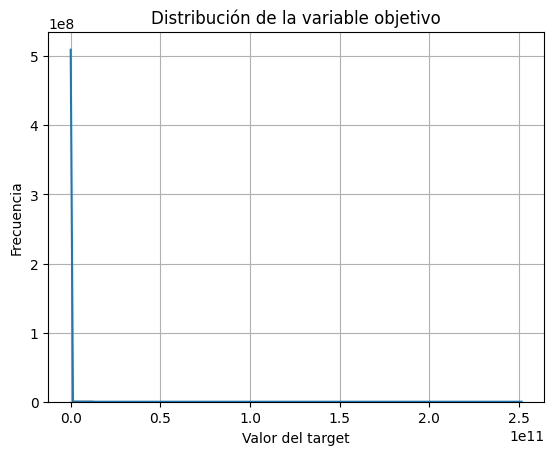

In [131]:
target = "Importe adjudicación sin impuestos"

sns.histplot(df[target], kde=True, bins=20)
plt.title('Distribución de la variable objetivo')
plt.xlabel('Valor del target')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

A priori podemos observar la amplia distribución de precios en nuestro dataset. Puede ser un indício de outliers y que deberemos tratar adecuadamente durante el desarrollo de este ejercicio pues la mayor parte de los importes son cantidades muy bajitas y observamos luego esa long tail. Posiblemente detectaremosoutliers pero no por ello serán valores irreales aunque haremos algún tipo de ajuste. No es lo mismo construir un aeropuerto que un sumninisro pequeño ue deba salir a licitación pública al superar un importe de 15.000€ (exigido en la Ley de Contratación del Sector Público)

<table style="border: none;">
<tr style="border: none;">
<td style="width: 55%; border: none;">

### **División de datos en Machine Learning**
[↑ Volver al índice](#índice)

Siempre debemos separar una parte de los datos para evaluar el modelo. Como no sabemos qué modelo funcionará mejor, probamos varios y elegimos el que tiene menos errores en el conjunto de **test**.

<details>
<summary><b>¿Cómo usar <code>train_test_split</code>?</b></summary>

- Separamos **features (X)** y **target (y)** con la misma cantidad de filas.  
- Indicamos el tamaño del test (ej. `test_size=0.2`).  
- Usa `random_state` para que la división sea reproducible.  
- La separación es aleatoria para evitar sesgos si los datos están ordenados.

</details>

**¿Cuánto usar para test?** Un **20%** lo consideramos equilibrado.

</td>
<td style="width: 45%; vertical-align: top; border: none;">

<!-- Imagen aquí -->
<img src="./src/img/datos_entrenamiento_grafico.jpg" alt="Imagen representativa" style="width: 100%; border-radius: 10px;"/>

</td>
</tr>
</table>

In [132]:
# Inicialmente prefiero dividir entre ttrain y test.train_test_split
# Para, posteriormente, quitar el target cuando vayamos a entrenar el modelo

train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)


---

####  *Punto de control*

A lo largo del proceso, vamos generando **versiones intermedias del dataset**, que guardamos al final de cada bloque de trabajo o capítulo. Estos **puntos de control** nos permiten:

* **Evitar repetir procesos costosos** en cada ejecución (como filtros, transformaciones o cálculos complejos).
* **Volver fácilmente a un estado anterior** si necesitamos revisar o modificar algún paso.
* **Ahorrar tiempo** y recursos, especialmente cuando trabajamos con grandes volúmenes de datos.

In [133]:
# Hacemos un punto de control.
# Guardamos el DataFrame en un archivo CSV por si fuese necesario volver a cargarlo
train_set.to_csv('./src/data/train_set_cp1.csv', index=False, encoding='utf-8')
print("Archivo CSV guardado como 'train_set_cp1.csv'")
test_set.to_csv('./src/data/test_set.csv', index=False, encoding='utf-8')
print("Archivo CSV guardado como 'test_set.csv'")

Archivo CSV guardado como 'train_set_cp1.csv'
Archivo CSV guardado como 'test_set.csv'



---

## <a name="capitulo2"></a>**2. Exploración y diagnóstico de calidad de datos**
[↑ Volver al índice](#índice)

Antes de comenzar a programar o construir modelos, es clave comprender bien el contexto del problema y conocer a fondo los datos con los que trabajamos. Este paso puede marcar la diferencia: a veces, con un análisis inicial sencillo, descubrimos que no necesitamos un modelo complejo, o que los datos disponibles no son suficientes para abordar la tarea prevista.

In [134]:
# Estadísticos
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
CPV,1297183.0,5.503013e+07,2.191068e+07,3.000000e+06,3.914311e+07,4.882000e+07,7.240000e+07,9.891000e+07
Tipo de contrato,1302929.0,2.764897e+00,1.568425e+01,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,9.990000e+02
Presupuesto base con impuestos,1264164.0,1.235428e+06,2.438659e+07,1.000000e-02,3.400000e+04,9.075000e+04,2.892533e+05,4.317800e+09
Presupuesto base sin impuestos,1302929.0,1.086074e+06,2.136240e+07,1.000000e-02,2.933884e+04,7.800000e+04,2.479339e+05,4.317800e+09
Valor estimado del contrato,1236600.0,1.570584e+06,2.587072e+07,0.000000e+00,3.702480e+04,9.900000e+04,3.450000e+05,5.090112e+09
ID OC en PLACSP,617625.0,3.139640e+13,1.395557e+13,1.000012e+13,2.103805e+13,3.101761e+13,4.126168e+13,1.216581e+14
Tipo de Procedimiento,1302929.0,1.289615e+01,7.813496e+01,1.000000e+00,1.000000e+00,3.000000e+00,9.000000e+00,9.990000e+02
Sistema de contratación,828383.0,4.731060e-01,1.098595e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
Tramitación,1302926.0,1.069875e+00,3.131694e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
Forma de presentación de la oferta,1161271.0,1.260162e+00,4.737779e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00


In [135]:
# dimensiones del dataset
print("Filas:", train_set.shape[0])
print("Columnas:", train_set.shape[1])

Filas: 1302929
Columnas: 40



Una buena práctica consiste en analizar cada variable del dataset de forma individual. Esta revisión puede hacerse en una hoja de cálculo y nos servirá como guía para entender mejor qué información tenemos, qué variables son relevantes y cómo se relacionan con el objetivo del análisis.

Para cada variable, conviene registrar:

- Nombre: el nombre o alias de la variable.

- Tipo de dato: por ejemplo, categórica, numérica, ordinal, continua, etc.

- Categoría: clasificación temática de la variable (demográfica, financiera, temporal, etc.).

- Utilidad esperada: una valoración subjetiva de si creemos que será útil para el modelo o si su información está duplicada en otra variable.

- Conclusión: juicio final sobre la relevancia de esa variable en el análisis.

¿Por qué es útil hacer esto?
Cuando tenemos muchos datos, hacer una primera selección visual (pero razonada) puede ayudarnos a reducir el ruido y enfocar el análisis en lo que realmente importa. Además, este trabajo previo puede prevenir errores en etapas posteriores y darnos una mejor orientación cuando surjan dudas o discrepancias durante el desarrollo del proyecto.



Dataset: licitaciones_resultados_consolidado.csv
Descripción: base de datos de licitaciones públicas en España, con información detallada sobre contratos, adjudicatarios, presupuestos y resultados de adjudicación.
Periodo:  2012-2025(julio)

| Columna/Variable | Descripción | Tipo_de_Variable | Importancia inicial | Nota |
|--------------------------------------------------|----------------------------------------------------------|------------------|----------------------|------|
| Número de expediente | Identificador único del procedimiento de licitación. | - | (0) A descartar | No es relevante para negocio |
| Link licitación | Enlace web a la licitación publicada. | - | (0) A descartar | No es relevante para negocio |
| Fecha de actualización                           | Última fecha de modificación del registro.                  | - | (0) A descartar | No es relevante para negocio |
| Objeto del Contrato                              | Descripción del propósito del contrato.                     | - | (0) A descartar | No es relevante para negocio |
| Vigente/Anulada/Archivada                        | Estado actual del expediente.                               | Categórica | Agrupación secundaria (3) | No creo tenga demaisado impacto sobre el target, únicamente da información sobre la vigencia de la licitación |
| Contrato mixto                                   | Indica si el contrato es de tipo mixto.                     | - | (0) A descartar | No es relevante para negocio |
| CPV                                              | Código CPV del contrato principal.                          | Numérica discreata | Agrupación importante (1) | Muy presumiblemente su CPV impacte en el precio final o descuento de los licitadores. Habrá tipos de obras o servicios que tengan más o menos competencia |
| Tipo de contrato                                 | Clasificación del contrato según su naturaleza.             | Categórica | Agrupación secundaria (3) | Puede ser influyente |
| Lugar de ejecución                               | Ubicación donde se ejecutará el contrato.                   | Numérica discreta | Agrupación interesante (2) | Hay ubicaciones en las que el precio pueda variar; disponibilidad de dar servicio/ejecutar trabajo, nivel de competencia,... |
| Presupuesto base con impuestos                   | Presupuesto total incluyendo impuestos.                     | - | (0) A descartar | Consideraremos las variables con importes sin IVA para unificar criterios |
| Presupuesto base sin impuestos                   | Presupuesto total sin incluir impuestos.                    | Numérica disscreta | Agrupación importante (1) | Es de esperar que a mayor importe los niveles de margen sean diferentes. hay gastos estructurales y pueden tener más impacto en contratos pequeños |
| Valor estimado del contrato                      | Valor económico estimado del contrato.                      | - | (0) A descartar | variable repetitiva |
| Órgano de contratación                           | Entidad responsable de la contratación.                     | Numérica discreta | Agrupación importante (1) | Seguramente existan ciertas inercias con determinadas administraciones y los licitadores, en función de la administración oferten con distinto nivel de descuento; facilidades de pago,... al final, exposición al riesgo |
| NIF OC                                           | Número de identificación fiscal del órgano de contratación. | - | (0) A descartar | Se selecciona otra variable al tener menos faltantes y que permite identificar al adjudicatario igualmente |
| ID OC en PLACSP                                  | Identificador del órgano en la plataforma PLACSP.           | - | (0) A descartar | Se selecciona otra variable al tener menos faltantes y que permite identificar al adjudicatario igualmente |
| Enlace al Perfil de Contratante del OC           | URL al perfil del contratante.                              | - | (0) A descartar | No es relevante para negocio |
| Tipo de Procedimiento                            | Tipo de procedimiento de adjudicación.                       Clasificación del contrato según su naturaleza.             | Categórica | Agrupación interesante (2) | Puede ser influyente |
| Sistema de contratación                          | Sistema utilizado para la contratación.                     | Categórica | Agrupación secundaria (3) | Puede ser influyente |
| Tramitación                                      | Tipo de tramitación del expediente.                         | Categórica | Agrupación secundaria (3) | Puede ser influyente |
| Forma de presentación de la oferta               | Método de entrega de las ofertas.                           | Categórica | Agrupación secundaria (3) | Puede ser influyente |
| Subasta electrónica                              | Indica si se usó subasta electrónica.                       | Categórica (Binaria) | Agrupación secundaria (3) | Puede ser influyente |
| Objeto de licitación/lote                        | Descripción del objeto do lote.                             | - | (0) A descartar | No es relevante para negocio a efectos de buscar el objetivo. Es un texto descriptivo|
| CPV licitación/lote                              | Código CPV o lote.                                          | - | (0) A descartar | Repetido |
| Presupuesto base con impuestos/lote               | - | (0) A descartar | Unificado el criterio a importes sin impuestos|
| Presupuesto base sin impuestos/lote              | Presupuesto del lote sin impuestos.                         | Numérica discreta | Agrupación importante (1) | Seguro es muy influyente por lo comentado. Mayores improtes pueden captar mayor interés para grandes corporaciones que pueden hacer mayor esfuerzo en descuentos, presupuestos menores puede provocar que la competencia esté muy atomizada y capten muchas ofertas de pequeños licitadores. Esto es un supuesto |
| Valor estimado licitación/lote                   | Valor estimado licitación o lote.                            | - | (0) A descartar | COnsideramos el presupuesto base, es una duplicidad |
| Lugar de ejecución licitación/lote               | Ubicación de ejecución o lote.                              | Numérica discreta | Agrupación interesante (2) | Hay ubicaciones en las que el precio pueda variar; disponibilidad de dar servicio/ejecutar trabajo, nivel de competencia,... |
| Resultado licitación/lote                        | Resultado final del proceso de licitación.                  | - | (0) A descartar | Dado el alto grado de faltantes podría afectar al modelo |
| Fecha del acuerdo licitación/lote                | Fecha de adjudicación del lote.                             | Categórica | Agrupación importante (1) | La variable temporal puede afectar al modelo pues los preicos sufren continuas subidas anuales, IPC y es de eperar que licitaciones futuras tengan un importe superior. Por eso hemos transformado y extraído el año, no tiene sentido tanta dispersión para objetivo de negocio |
| Número de ofertas recibidas por licitación/lote  | Cantidad de ofertas recibidas.                              | Numérica Discreta | Agrupación importante (1) | Eñl nivel de competencia (medido por ofertas recibidas), puede afectar en el importe final de adjudicación |
| Precio de la oferta más baja                     | Importe de la oferta más económica.                         | - | (0) A descartar | Consideraríamos directamente los outliers pues pueden darse incluso ofertas anormalmente bajas |
| Precio de la oferta más alta                     | Importe de la oferta más costosa.                           | - | (0) A descartar | Consideraríamos directamente los outliers. En esta ocasión, por arriba |
| Se han excluido ofertas anormalmente bajas       | Indica si hubo exclusiones por baja temeraria.              | - | (0) A descartar | Consideraríamos directamente los outliers, ofertas anormalmente bajas |
| Número de contrato                               | Identificador del contrato adjudicado.                      | - | (0) A descartar | No es relevante para negocio |
| Fecha formalización del contrato                 | Fecha de firma del contrato.                                | Categórica | Agrupación interesante (2) | Puede ser que, en función de cuándo se firme el contrato pueda ser relevante para una compañía hacer un mayor o menor esfuerzo económico. Si necesita negocio y puede entrar un contrato en un momento determinado, puede impactar en el precio que ofrezca. Por eso hemos transformado y extraído el año, no tiene sentido tanta dispersión para objetivo de negocio |
| Adjudicatario                                    | Entidad que ganó la licitación.                             | Numérica discreta | Agrupación importante (1) | Estrategias empresariales pueden ser más o menos agresivas y ofrecer servicios a precios tan competitivos que incluso con menor valor de descuento hubieran podido ganar |
| Identificador adjudicatario                      | Código identificador del adjudicatario.                     | - | (0) A descartar | No es relevante para negocio |
| Tipo de identificador de adjudicatario           | Tipo de documento identificador.                            | - | (0) A descartar | No es relevante para negocio |
| Importe adjudicación sin impuestos               | Importe final adjudicado sin impuestos.                     | Categórica discreta | Target / Directora (0) | Podríamso considerar como target la variable 'Descuento adjudicatario' como hemos indicado al seleccionar el target |
| Importe adjudicación con impuestos               | Importe final adjudicado con impuestos.                     | - | (0) A descartar | Consideramos exclusivamente importes sin impuestos |
| Descuento adjudicatario                          | Descuento aplicado por el adjudicatario.                    | Numérica discreta | Agrupación importante (1) |


Aunque los datos están bien definidos en el análisis exploratorio previo, vamos a forzarlo de igual modo.
Especial interés tendrá los datos tipo fecha para que luego podamos sacar estadísticos (lo convertiremos en numérica discreta o categórica) pues anualizaremos las fechas. Sólo tendrá sentido ve si se produce algún cambio anualmente.

Por supuesto, probablemente haya missings en los datos. La conversión de estos missings da error, pero lo solventamos (de momento) con el argumento `errores='ignore'`.

In [136]:
# Nos aseguramos los tipos de las variables
train_set = mytb.controlar_tipos(train_set)

Un pequeño reporte de las columnas, con sus tipos, % de missings y cardinalidad, resultará muy útil a lo largo de la analítica.

In [137]:
# Comprobamos que se han cambiado los tipos de datos      
mytb.data_report(train_set)

COL_N,Número de expediente,Link licitación,Fecha de actualización,Objeto del Contrato,Vigente/Anulada/Archivada,Contrato mixto,CPV,Tipo de contrato,Lugar de ejecución,Presupuesto base con impuestos,...,Precio de la oferta más baja,Precio de la oferta más alta,Se han excluido ofertas anormalmente bajas,Número de contrato,Fecha formalización del contrato,Adjudicatario,Identificador adjudicatario,Tipo de identificador de adjudicatario,Importe adjudicación sin impuestos,Importe adjudicación con impuestos
DATA_TYPE,object,object,object,object,bool,bool,float64,int64,object,float64,...,float64,float64,bool,object,object,object,object,object,float64,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,2.98,...,49.99,50.35,0.0,37.47,31.44,0.0,0.0,0.0,0.0,2.98
UNIQUE_VALUES,606765,697132,1297204,660416,1,1,6843,12,165,371361,...,186864,201154,2,358227,5218,229912,115422,3,404643,411702
CARDIN (%),46.57,53.5,99.56,50.69,0.0,0.0,0.53,0.0,0.01,28.5,...,14.34,15.44,0.0,27.49,0.4,17.65,8.86,0.0,31.06,31.6


### <a name="eliminacion-irrelevantes"></a>**Eliminación de features irrelevantes**
[↑ Volver al índice](#índice)  

No todas las variables del dataset aportan valor al análisis o al modelo. Algunas pueden ser identificadores únicos (como códigos, nombres o IDs), otras pueden estar altamente correlacionadas con otras variables, o simplemente contener información redundante o irrelevante para el objetivo del estudio.

Eliminar estas variables desde el inicio nos permite:

- Reducir el ruido en el análisis.

- Mejorar el rendimiento de los modelos.

- Aumentar la interpretabilidad de los resultados.

Este proceso debe hacerse con criterio, valorando tanto la lógica de negocio como la estructura del dataset, para evitar eliminar información útil de forma prematura.

In [138]:
# Reduccion preliminar de features
features_a_eliminar = ["Tramitación",                                # En el desarrollo del ejercicio vimso que sólo tenía un valor. Feature irrelevante
                       "Subasta electrónica",                        # En el desarrollo del ejercicio vimso que sólo tenía un valor. Feature irrelevante
                        "Contrato mixto",                            # En el desarrollo del ejercicio vimso que sólo tenía un valor. Feature irrelevante
                        "Vigente/Anulada/Archivada",                 # En el desarrollo del ejercicio vimso que sólo tenía un valor. Feature irrelevante
                        "Link licitación",                           # No tiene relevancia para el objetivo de negocio
                        "Presupuesto base con impuestos",            # Valor duplicado. Lo tenemos in impuestos que es más riguroso para el ejercicio
                        "Presupuesto base sin impuestos/lote",       # Valor duplicado. Lo tenemos in impuestos que es más riguroso para el ejercicio
                        "Valor estimado licitación/lote",            # Valor sin relevancia para el ejercicio pues el 'Presupuesto base sin impuestos' es el valor maximo admisible en el contrato
                        "Valor estimado del contrato",               # Valor sin relevancia para el ejercicio pues el 'Presupuesto base sin impuestos' es el valor maximo admisible en el contrato
                        "Presupuesto base con impuestos/lote",       # Unifciamos todos los importes sin impuestos.
                        "Fecha de actualización",                    # Lamentablemente nuestras administraciones son perezosas y el número de altantes afecta enormemente al resultado
                        "Objeto del Contrato",                       # No tiene relevancia para el objetivo de negocio al ser una desripción del contrato
                        "Resultado licitación/lote",                 # Sin interés para negocio
                        "NIF OC",                                    # Lamentablemente nuestras administraciones son perezosas pero sería lo ideal para crear un registro unívoco, primarykey, lo haremos con 'Órgano de contratación' esperando no tener demasiadas erratas que dupliquen valores
                        "ID OC en PLACSP",                           # Lamentablemente nuestras administraciones son perezosas pero sería lo ideal para crear un registro unívoco, primarykey, lo haremos con 'Órgano de contratación' esperando no tener demasiadas erratas que dupliquen valores
                        "Enlace al Perfil de Contratante del OC",    # Sin relevancia para el objetivo de negocio
                        "Objeto de licitación/lote",                 # El número de faltantes es relevante y preferimos que no impacte en el objetivo de negocio
                        "CPV licitación/lote",                       # Vlaor duplicado, ya tenemos los CPV del contrato
                        "Número de contrato",                        # Sin relevancia para el objetivo de negocio
                        "Importe adjudicación con impuestos",        # Hemos normalizado los importes sin impuestos. Descartamos con impuestos
                        "Tipo de identificador de adjudicatario",    # Sin impacto para el objetivo de negocio
                        "Identificador adjudicatario",               # Valor duplicado, tomamos el nombre
                        "Precio de la oferta más baja",              # Elimino esta columna pues puede representar un outlier y afectar a mi modelo predictivo
                        "Precio de la oferta más alta" ,             # Elimino esta columna pues puede representar un outlier y afectar a mi modelo predictivo
                        "Se han excluido ofertas anormalmente bajas" # Es otra forma de llamar a los outliers y puede afectar al modelo.
                        ] 
train_set = train_set.drop(columns = features_a_eliminar)
train_set = train_set.copy()

Una feature selection también será relevante. Es momento de eliminar todos aquellos registros y features que puedan afectar a:  
- La velocidad de ejecución del modelo tratando un volumen de datos irrelevante que sólo pueden,
- Impactar en el modelo, overfitting

In [139]:
# Filtramos solo las columnas numéricas
numeric_df = train_set.select_dtypes(include='number')

# Calculamos la correlación absoluta con la variable objetivo
corr = np.abs(numeric_df.corr()[target]).sort_values(ascending=True)
print(corr)

bad_corr_feat = corr[corr < 0.2].index.values
bad_corr_feat

Número de ofertas recibidas por licitación/lote    0.000014
Tipo de contrato                                   0.000050
Forma de presentación de la oferta                 0.000201
CPV                                                0.000285
Presupuesto base sin impuestos                     0.019394
Importe adjudicación sin impuestos                 1.000000
Name: Importe adjudicación sin impuestos, dtype: float64


array(['Número de ofertas recibidas por licitación/lote',
       'Tipo de contrato', 'Forma de presentación de la oferta', 'CPV',
       'Presupuesto base sin impuestos'], dtype=object)

In [140]:
# Exclusiones
excluir = ['CPV',                               # Veremos posteriormente, cuando creemos nuestra nueva metrica que podrá ser relevante considerando distinto nivel de descuento para los distintos servicios y trabajos
           'Presupuesto base sin impuestos']    # Creo es fundamental aunque pueda no estar bien correlacionada y posiblemente impacte en mi modelo
bad_corr_feat = [col for col in bad_corr_feat if col not in excluir]

print(bad_corr_feat)

train_set.drop(columns=bad_corr_feat, inplace=True)
train_set.info()

['Número de ofertas recibidas por licitación/lote', 'Tipo de contrato', 'Forma de presentación de la oferta']
<class 'pandas.core.frame.DataFrame'>
Index: 1302929 entries, 718719 to 157490
Data columns (total 12 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   Número de expediente                1302929 non-null  object 
 1   CPV                                 1297183 non-null  float64
 2   Lugar de ejecución                  1302929 non-null  object 
 3   Presupuesto base sin impuestos      1302929 non-null  float64
 4   Órgano de contratación              1302929 non-null  object 
 5   Tipo de Procedimiento               1302929 non-null  object 
 6   Sistema de contratación             1302929 non-null  object 
 7   Lugar de ejecución licitación/lote  1302929 non-null  object 
 8   Fecha del acuerdo licitación/lote   1205004 non-null  object 
 9   Fecha formalización del contrato    

#### Feature importance 

No tiene demasiado sentido en tanto en cuánto sólo tengo dos variables numéricas,
- Presupuesto base sin impuestos
- Importe adjudicación sin impuestos (target)

In [141]:
X = train_set.drop(columns=[target])
y = train_set[target]

##### RandomForest

In [ ]:
# Filtramos solo las columnas numéricas
X_numeric = X.select_dtypes(include='number')

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_numeric, y)

names = X_numeric.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
importancia_df = pd.DataFrame(scores, columns=['Score', 'Feature'])
importancia_df

##### Feature importance estadístico

In [ ]:
# Eliminamos valores nulos para evitar posibles errores al aplicar SelectKBest
X_numeric_clean = X_numeric.dropna()
y_clean = y.loc[X_numeric_clean.index]

sel = SelectKBest(score_func=f_regression, k=5)
X_new = sel.fit_transform(X_numeric_clean, y_clean)

names = X_numeric_clean.columns
feature_scores = pd.DataFrame({'column': names, 'score': sel.scores_})
print(feature_scores.sort_values('score', ascending=False))

Posteriormente, si realizamos un encoding a nuestras variables tpo string, podríamos realizar un análisis más detallado incluyendo estas features. Pero, en esta fase preliminar, este análisis sería suficiente.

### <a name="analisis-uni-bivariado"></a>**Análisis univariante y bivariante**

#### **Análisis univariante**
[↑ Volver al índice](#índice)  

Una de las primeras tareas al explorar un dataset consiste en observar cada variable por separado. Este análisis univariante nos permite entender la distribución de los datos, detectar valores atípicos y hacernos una idea general de su comportamiento.

Dependiendo del tipo de variable, los gráficos que solemos utilizar son:

- Variables categóricas: se representan con gráficos de barras, que muestran la frecuencia de cada categoría.

- Variables numéricas: se visualizan con histogramas, que permiten ver la distribución de los valores y su dispersión.

Para agilizar esta fase inicial, hemos desarrollado una función de carga ultrarrápida que genera automáticamente estas visualizaciones con un simple comando. Está optimizada para manejar grandes volúmenes de datos y permite obtener una visión rápida y clara de nuestras variables desde el primer momento del análisis. Ideal para una exploración preliminar sin complicaciones.

In [ ]:
# Analisis univariante ultrarrapido
data_uni, feat_cat, feat_num = mytb.card_tipo(train_set)
print(f"Variables categoricas: {feat_cat}")
print(f"Variables numéricas: {feat_num}")
mytb.analisis_univariante_ultrarrapido(train_set, feat_cat, feat_num)

#### **Análisis bivariante con target numérico**
[↑ Volver al índice](#índice)  

Una vez entendido el comportamiento individual de cada variable, el siguiente paso lógico es estudiar cómo se relacionan con nuestro target, que en este caso es una variable numérica. Este análisis bivariante nos ayuda a identificar qué variables podrían tener mayor capacidad predictiva y a detectar posibles relaciones lineales o no lineales.

Según el tipo de variable explicativa, los gráficos recomendados son:

- Variables numéricas: se utiliza principalmente el diagrama de dispersión (scatter plot), que permite ver la correlación o tendencia entre la variable y el target.

- Variables categóricas: es útil un boxplot, que muestra la distribución del target para cada categoría y nos permite detectar diferencias entre grupos.

Para facilitar este paso, contamos también con una función visual rápida, diseñada para generar este tipo de gráficos de forma automática y eficiente, incluso con datasets grandes. Esto permite detectar rápidamente patrones relevantes sin necesidad de configurar cada gráfico manualmente. Ideal para avanzar con agilidad en esta primera fase exploratoria.

In [ ]:
# Analisis bivariante ultrarrapido
mytb.analisis_bivariante_ultrarrapido(train_set, feat_cat, feat_num, target=target)

### <a name="duplicados"></a>**Duplicados**
[↑ Volver al índice](#índice)  

En muchos sistemas, especialmente en plataformas de contratación, es común que se genere un nuevo registro cada vez que un expediente se actualiza o avanza de fase. Esto provoca que tengamos múltiples filas asociadas al mismo expediente, aunque con ligeras variaciones según el estado o momento del proceso.

Para evitar distorsiones en el análisis, es importante **eliminar duplicados** y quedarnos con un único registro por expediente. La lógica de selección puede variar según el caso: el más reciente, el primero, o el que contenga determinada información clave. En cualquier caso, esta depuración inicial es fundamental para no contar varias veces el mismo caso y asegurar una lectura coherente de los datos.


In [146]:
# Eliminamos duplicados
# Se crean muchos registros para la misma licitacion según avanza el proceso; anuncio licitación, adjudicación, formalización, etc.
train_set = train_set.drop_duplicates(subset='Número de expediente', keep='last')

# Aprovechamos para eliminar esta columna que no aporta nada al objetivo de negocio pero era fundamental para eliminar duplicados
train_set = train_set.drop(['Número de expediente'], axis=1)

### <a name="missings"></a>**Missings**
[↑ Volver al índice](#índice)

La presencia de valores nulos o ausentes es algo habitual en cualquier conjunto de datos. En algunos casos se debe a errores de registro, en otros simplemente a que cierta información no era aplicable en el momento de carga.

Antes de modelar o analizar, es importante identificar y tratar adecuadamente estos valores. Algunas variables pueden tener ausencias irrelevantes, pero en otras, los missings pueden afectar directamente a la calidad de las conclusiones. Según el caso, podremos optar por:

- Eliminar filas o columnas con muchos valores nulos.

- Rellenar los huecos con valores representativos (media, mediana, cero, etc.).

- Etiquetar explícitamente la ausencia como una categoría.

Este paso es clave para asegurar la consistencia de los datos y evitar errores silenciosos durante el análisis.

In [ ]:
# # Resolvemos Missings de forma manual
train_set = mytb.imputar_y_transformar_fechas(train_set)

Además integraremos una pequeña función para **eliminar missings** de forma automática en función del porcentaje de los mismos. Alcanzado un umbral, puede ser más relevante su eliminación de nuestros datos de entrenamiento.

In [148]:
precent_missing = train_set.isnull().sum()*100/len(train_set)
missing_value_df = pd.DataFrame({'column_name': train_set.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
CPV,CPV,0.432128
Lugar de ejecución,Lugar de ejecución,0.000000
Presupuesto base sin impuestos,Presupuesto base sin impuestos,0.000000
Órgano de contratación,Órgano de contratación,0.000000
Tipo de Procedimiento,Tipo de Procedimiento,0.000000
Sistema de contratación,Sistema de contratación,0.000000
Lugar de ejecución licitación/lote,Lugar de ejecución licitación/lote,0.000000
Fecha del acuerdo licitación/lote,Fecha del acuerdo licitación/lote,0.000000
Fecha formalización del contrato,Fecha formalización del contrato,0.000000
Adjudicatario,Adjudicatario,0.000000


In [149]:
cols_to_drop_missings = missing_value_df[missing_value_df['percent_missing'] > 50].index.values
print("Cols:", cols_to_drop_missings)

print("Columnas pre drop:", len(train_set.columns))
train_set.drop(columns=cols_to_drop_missings, inplace=True)
print("Columnas post drop:", len(train_set.columns))

Cols: []
Columnas pre drop: 11
Columnas post drop: 11


### <a name="outliers"></a>**Outliers**
[↑ Volver al índice](#índice)

En esta fase del análisis, vamos a eliminar los **valores atípicos más extremos, outliers** que aparecen en la parte superior de algunas variables, especialmente en el **"Importe adjudicación sin impuestos"**. Este tipo de valores, aunque pueden ser reales, suelen falsear el comportamiento general del modelo y desviar las métricas si no se tratan adecuadamente.

Para ello, aplicaremos un recorte conservador eliminando los registros **por encima del percentil 99.9 (0.999 quantile)**. De esta forma, preservamos casi toda la información útil, pero evitamos que unos pocos valores desproporcionados condicionen el análisis o el entrenamiento del modelo.

In [150]:
# Calculamos el percentil 99
umbral_superior = train_set[target].quantile(0.999)

# Filtramos los datos para eliminar los outliers por arriba
train_set = train_set[train_set[target] <= umbral_superior]
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606158 entries, 1712175 to 157490
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CPV                                 603539 non-null  float64
 1   Lugar de ejecución                  606158 non-null  object 
 2   Presupuesto base sin impuestos      606158 non-null  float64
 3   Órgano de contratación              606158 non-null  object 
 4   Tipo de Procedimiento               606158 non-null  object 
 5   Sistema de contratación             606158 non-null  object 
 6   Lugar de ejecución licitación/lote  606158 non-null  object 
 7   Fecha del acuerdo licitación/lote   606158 non-null  int32  
 8   Fecha formalización del contrato    606158 non-null  int32  
 9   Adjudicatario                       606158 non-null  object 
 10  Importe adjudicación sin impuestos  606158 non-null  float64
dtypes: float64(3), int32(2), 

### <a name="anomalías"></a>**Anomalías y errores**
[↑ Volver al índice](#índice)

Tras los análisis previos de duplicados, valores ausentes, outliers y coherencia interna entre variables, sólo se ha identificado que la variable **'Importe adjudicación sin impuestos' presenta valores negativos**  en el dataset. 

Aseguramos que se eliminen estos registros. El resto de datos presentan una estructura consistente y razonable, lo que permite continuar con el análisis sin necesidad de realizar correcciones adicionales en esta fase.


In [151]:
# Eliminamos los valores anomalos
# Podríamos igualarlos a cero pero dudamos de su consistencia.
train_set = train_set[train_set[target] > 0]


---

####  *Punto de control*

Nuevo punto de control al final de cada capítulo.

In [152]:
# Hacemos un punto de control.
# Guardamos el DataFrame en un archivo CSV por si fuese necesario volver a cargarlo
train_set.to_csv('./src/data/train_set_cp2.csv', index=False, encoding='utf-8')
print("Archivo CSV guardado como 'train_set_cp2.csv'")
train_set.info()

Archivo CSV guardado como 'train_set_cp2.csv'
<class 'pandas.core.frame.DataFrame'>
Index: 597943 entries, 1712175 to 157490
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   CPV                                 595391 non-null  float64
 1   Lugar de ejecución                  597943 non-null  object 
 2   Presupuesto base sin impuestos      597943 non-null  float64
 3   Órgano de contratación              597943 non-null  object 
 4   Tipo de Procedimiento               597943 non-null  object 
 5   Sistema de contratación             597943 non-null  object 
 6   Lugar de ejecución licitación/lote  597943 non-null  object 
 7   Fecha del acuerdo licitación/lote   597943 non-null  int32  
 8   Fecha formalización del contrato    597943 non-null  int32  
 9   Adjudicatario                       597943 non-null  object 
 10  Importe adjudicación sin impuestos  597943 no


---

## <a name="capitulo3"></a>**3. Ingeniería de variables**
[↑ Volver al índice](#índice)

En esta etapa se transformarán las variables existentes y se generarán nuevas, con el objetivo de mejorar el rendimiento de los modelos.

En este bloque vamos a analizar qué variables numéricas pueden beneficiarse de una transformación de escala (como logarítmica o Box-Cox) para corregir sesgos en su distribución y mejorar su comportamiento en modelos sensibles a la normalidad.

Variables candidatas a transformación:
Aquellas variables numéricas que presentan colas largas a la derecha (long tail) y que guarden ordinalidad, por lo que tienen sentido aplicar transformaciones:

- Presupuesto base sin impuestos
- Importe adjudicación sin impuestos

Se analizarán distintas transformaciones para observar mejoras en simetría y normalidad.

Variables excluidas del análisis de transformación:
Otras variables, aunque tienen una distribución desbalanceada, no son realmente continuas ni representan ordinalidad. Se trata de variables categóricas codificadas como numéricas, donde la magnitud del número no tiene significado:

- Sistema de contratación
- Órgano de contratación
- Tipo de procedimiento
- Contrato mixto

Aplicar transformaciones estadísticas sobre estas variables no tendría sentido, ya que su valor representa categorías y no cantidades. En su lugar, se tratarán como variables categóricas para codificación posterior (por ejemplo, one-hot encoding u otro tipo de encoding).


Variable: Presupuesto base sin impuestos


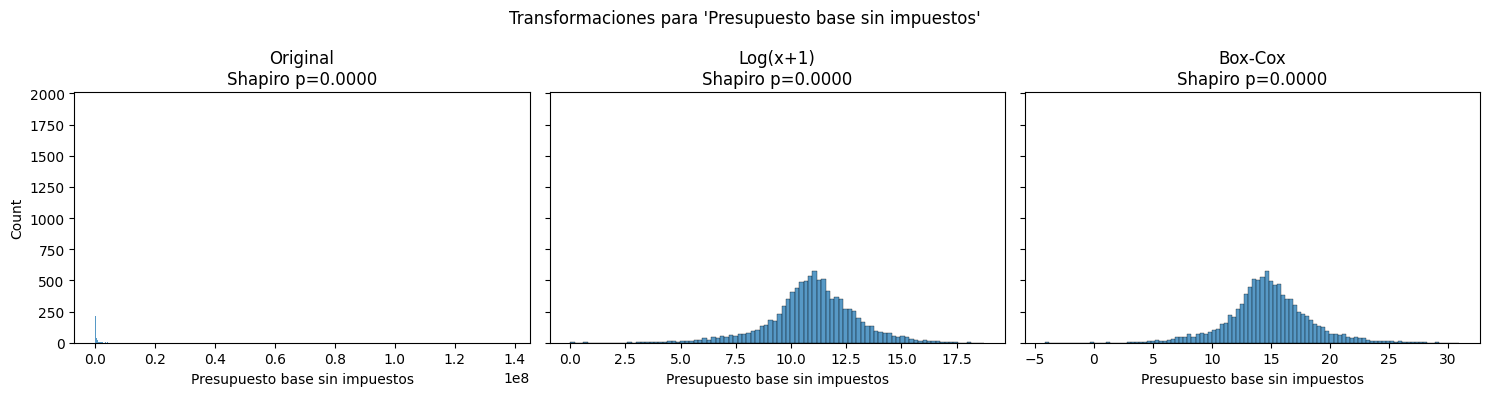


Variable: Importe adjudicación sin impuestos


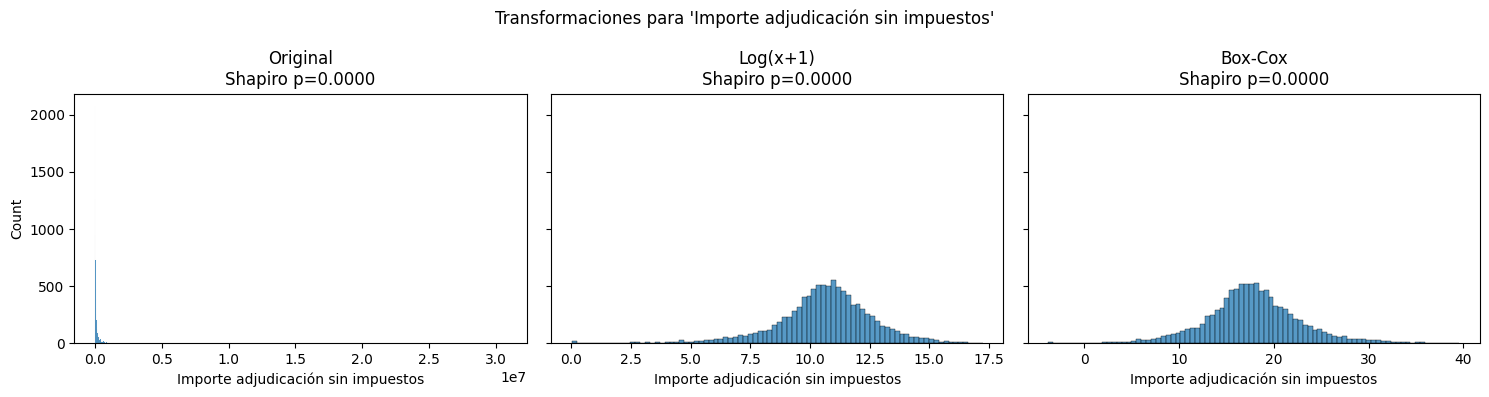

In [153]:
# Transformamos nuestras variables numéricas para mejorar la normalidad de la distribución
vars_candidatas = [
    "Presupuesto base sin impuestos",
    target]
mytrans.analizar_transformaciones(train_set, vars_candidatas)

Aunque ambas trnasformaciones presentan resultados similares asimilable a una distribución normal, Box-Cox presenta una mayor simetría. Por lo tanto, utilizaremos Box-Cox para transformar las variables seleccionadas.

### <a name="codificacion"></a>**Codificación**
[↑ Volver al índice](#índice)

Los modelos de Machine Learning están diseñados para trabajar con datos numéricos. Sin embargo, muchos datasets del mundo real contienen variables tipo objeto (por ejemplo: "Provincia", "Tipo de contrato", "Adjudicatario"), que están representadas como texto o etiquetas (strings, object en pandas). Si no se transforman adecuadamente, estos modelos no pueden procesarlas.  

Para este proyecto, implementamos la función auto_encoding, que selecciona automáticamente el tipo de codificación más adecuado para cada variable categórica en base a su cardinalidad:

- Categorías numéricamente altas → Frequency Encoding o lo que otra literatura considera Count encoding

- Categóricas → One-Hot Encoding

Esta decisión se basa en la función card_tipo(df), que analiza la cantidad de valores únicos y sugiere si la variable debe ser tratada como “categórica” o “numérica”.

##### **Nuestro Enfoque en este proyecto**

**One-Hot Encoding**. Convierte cada categoría en una columna binaria (0 o 1). Ideal para variables con baja cardinalidad (pocas categorías distintas).

Ej.: "Tipo de Procedimiento" con valores como Abierto, Negociado, etc.

**Hashing Encoding (FeatureHasher)**. Reemplaza las categorías por un conjunto fijo de columnas numéricas usando funciones hash. Adecuado para variables con alta cardinalidad, donde One-Hot sería ineficiente o inviable. Evita crear un diccionario o mapa explícito de categorías. Introduce el riesgo de colisiones (diferentes categorías mapeadas a la misma representación), pero es eficiente en memoria y velocidad.

Ejemplo: "Adjudicatario", con miles de valores únicos.


**Frequency Encoding o Count Encoding**. Otra opción pero menos eficiente que el método FeatureHasher. Reemplaza cada categoría con la frecuencia relativa con la que aparece en el dataset. Útil para variables de alta cardinalidad (muchas categorías distintas). Reduce dimensionalidad comparado con One-Hot.

Ej.: "Adjudicatario", con miles de nombres distintos.

*Target Encoding* (no usado aquí). Sustituye las categorías por el promedio del target dentro de cada categoría. Requiere validación cruzada para evitar sobreajuste.

In [154]:
train_set = mytb.auto_encoding(train_set)

Procesando: CPV
Procesando: Lugar de ejecución
  Hashing Encoding (alta cardinalidad) para 'Lugar de ejecución'
Procesando: Presupuesto base sin impuestos
Procesando: Órgano de contratación
  Hashing Encoding (alta cardinalidad) para 'Órgano de contratación'
Procesando: Tipo de Procedimiento
  One-Hot Encoding para 'Tipo de Procedimiento'
Procesando: Sistema de contratación
  One-Hot Encoding para 'Sistema de contratación'
Procesando: Lugar de ejecución licitación/lote
  Hashing Encoding (alta cardinalidad) para 'Lugar de ejecución licitación/lote'
Procesando: Fecha del acuerdo licitación/lote
Procesando: Fecha formalización del contrato
Procesando: Adjudicatario
  Hashing Encoding (alta cardinalidad) para 'Adjudicatario'
Procesando: Importe adjudicación sin impuestos


### <a name="nuevas-variables"></a>**Nuevas variables**
[↑ Volver al índice](#índice)  

En el análisis de contratos públicos, una vmétrica particularmente relevante para evaluar el comportamiento del mercado y la eficiencia en la adjudicación es el **"Descuento adjudicatario"**. Esta métrica refleja qué porcentaje del presupuesto inicial estimado fue finalmente adjudicado al proveedor.

¿Por qué es útil?

- Permite identificar contratos adjudicados con un alto o bajo nivel de competencia.

- Puede revelar patrones interesantes si se relaciona con otras variables como el adjudicatario, el tipo de procedimiento o el órgano de contratación.


In [155]:
# Calculamos nuestra nueva métrica
train_set["Descuento_adjudicatario"] = (
    (train_set["Presupuesto base sin impuestos"] - train_set["Importe adjudicación sin impuestos"]) /
    train_set["Presupuesto base sin impuestos"]
).round(5)

# Eliminamos los registros anómalos, con valores de descuento negativo y/o iguales a 1. Nadie hace un descuento del 100%...
train_set = train_set[(train_set["Descuento_adjudicatario"] > 0) & (train_set["Descuento_adjudicatario"]< 1)]
# Mostramos datos estadísticos de la nueva métrica
train_set["Descuento_adjudicatario"].describe().T

count    409667.000000
mean          0.273339
std           0.269203
min           0.000010
25%           0.066670
50%           0.186520
75%           0.385645
max           0.999990
Name: Descuento_adjudicatario, dtype: float64

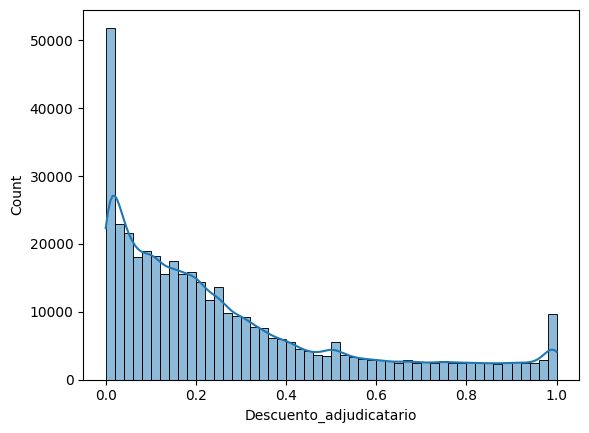

In [156]:
# graficamos para ver su distribución
sns.histplot(train_set["Descuento_adjudicatario"], bins=50, kde=True)
plt.show()

### <a name="escalado"></a>**Escalado de variables**
[↑ Volver al índice](#índice)

En Machine Learning, el escalado de variables es una etapa fundamental del preprocesamiento cuando tus datos contienen características numéricas con rangos muy diferentes.

##### ¿Qué ocurre si no escalamos?  

Algunos modelos se ven muy afectados por la dispersión de valores (por ejemplo, Importe adjudicación en millones vs. variables binarias).

Esto puede distorsionar el aprendizaje del modelo, reducir su rendimiento y hacer que el entrenamiento tarde más o no converja.

Modelos como regresión lineal, SVM, k-NN, redes neuronales o PCA pueden interpretar que una variable con valores grandes tiene más importancia que otra, simplemente por su escala. Modelos basados en árboles de decisión no se verán especialmente (afectados al no basarse en distancias) aunque tampoco les vendrá mal.  

| Método           | Qué hace                              | Cuándo usarlo                                                        |
| ---------------- | ------------------------------------- | -------------------------------------------------------------------- |
| `StandardScaler` | Centra en media 0 y varianza 1        | Cuando los datos se distribuyen normal o transformados como log(x+1) |
| `MinMaxScaler`   | Escala entre 0 y 1                    | Cuando se requiere preservar la forma y límites del rango            |
| `RobustScaler`   | Usa mediana y IQR, robusto a outliers | Cuando hay outliers extremos                                         |


In [157]:
# Escalamos las variables numéricas
train_set = mytrans.transformar_boxcox_escalar(train_set)
train_set

TypeError: transformar_boxcox_escalar() missing 1 required positional argument: 'columnas'

Este es el resultado de nuestro dataset de entrneamiento una vez completadas las transformaciones.

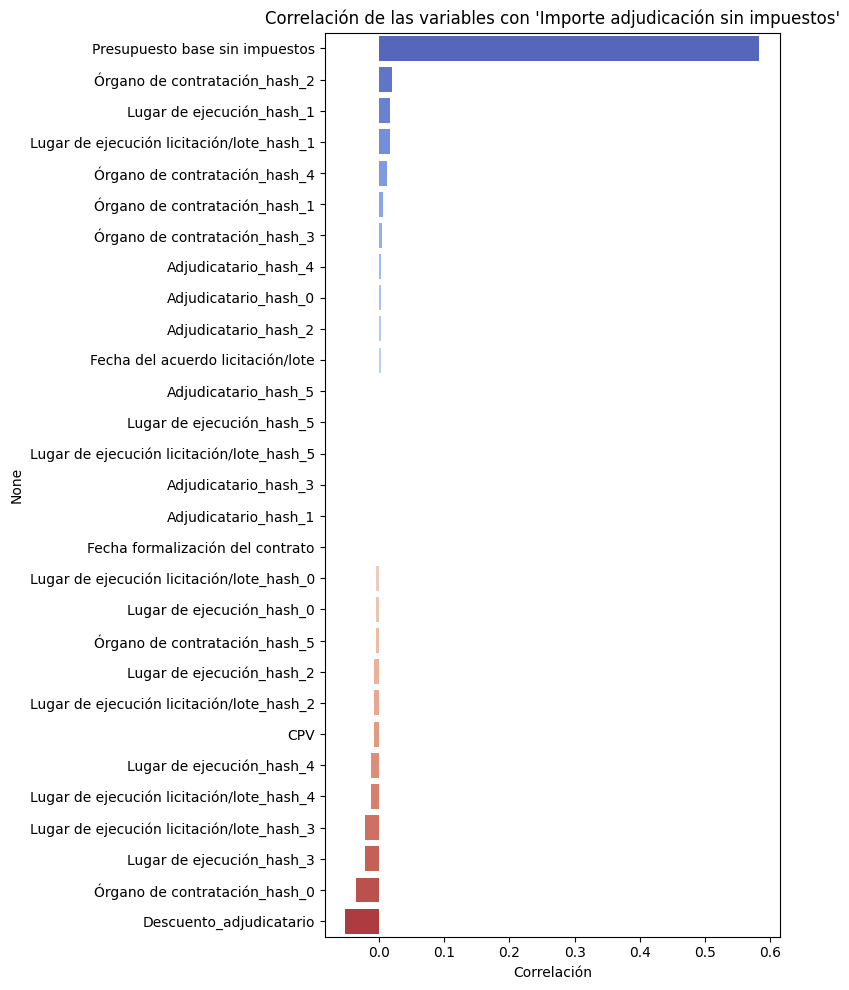

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos solo numéricas
df_num = train_set.select_dtypes(include='number')

# Correlación frente a la target
target_col = "Importe adjudicación sin impuestos"
correlaciones = df_num.corr()[target_col].drop(target_col).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x=correlaciones.values, y=correlaciones.index, palette="coolwarm")
plt.title(f"Correlación de las variables con '{target_col}'")
plt.xlabel("Correlación")
plt.tight_layout()
plt.show()


---

####  *Punto de control*


In [34]:
# Hacemos un nuevo punto de control.
# Guardamos el DataFrame en un archivo CSV por si fuese necesario volver a cargarlo
train_set.to_csv('./src/data/train_set_cp3.csv', index=False, encoding='utf-8')
print("Archivo CSV guardado como 'train_set_cp3.csv'")
train_set.info()

Archivo CSV guardado como 'train_set_cp3.csv'
<class 'pandas.core.frame.DataFrame'>
Index: 409667 entries, 1712175 to 157490
Data columns (total 49 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   CPV                                        408775 non-null  float64
 1   Presupuesto base sin impuestos             409667 non-null  float64
 2   Fecha del acuerdo licitación/lote          409667 non-null  int32  
 3   Fecha formalización del contrato           409667 non-null  int32  
 4   Importe adjudicación sin impuestos         409667 non-null  float64
 5   Lugar de ejecución_hash_0                  409667 non-null  float64
 6   Lugar de ejecución_hash_1                  409667 non-null  float64
 7   Lugar de ejecución_hash_2                  409667 non-null  float64
 8   Lugar de ejecución_hash_3                  409667 non-null  float64
 9   Lugar de ejecución_hash_4         


---

## <a name="capitulo4"></a>**4. Selección de modelo y validación**

Se seleccionará el modelo más adecuado para el problema, se ajustarán hiperparámetros y se validará con distintas técnicas.


### <a name="eleccion-metrica"></a>**Elección de métrica**
[↑ Volver al índice](#índice)

Dado que trabajamos con variables económicas como "Importe adjudicación sin impuestos", "Presupuesto base sin impuestos" recomendamos una combinación de las siguientes métricas:
1. **MAE** para interpretar el error promedio en euros o en escala natural

2. **RMSE** para dar más peso a errores grandes

3. **R² Score** para ver cuánta variabilidad estás explicando

In [60]:
train_set = pd.read_csv("./src/data/train_set.csv")
test_set = pd.read_csv("./src/data/test_set.csv")

In [61]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metricas_regresion(datf, target_col):
    """
    Calcula y muestra métricas de regresión usando HistGradientBoostingRegressor
    que admite NaNs nativamente.

    Parámetros:
    -----------
    datf : pd.DataFrame
        DataFrame con las características y la variable objetivo.
    target_col : str
        Nombre de la columna objetivo.

    Retorna:
    --------
    None
    """
    modelo = HistGradientBoostingRegressor()
    X = datf.drop(columns=[target_col])
    Y = datf[target_col]

    modelo.fit(X, Y)
    preds = modelo.predict(X)

    print("R² score:", round(r2_score(Y, preds), 4))
    print("MAE:", round(mean_absolute_error(Y, preds), 4))
    print("MSE:", round(mean_squared_error(Y, preds), 4))
    print("RMSE:", round(np.sqrt(mean_squared_error(Y, preds)), 4))
    print("MAPE:", round(mean_absolute_percentage_error(Y, preds), 4))

metricas_regresion(train_set, target)

R² score: 0.9643
MAE: 25086.1685
MSE: 61328691650.675
RMSE: 247646.3035
MAPE: 3884.9585


In [ ]:
# Aplicamos las mismas transformaciones manuales a test que no están en el Pipeline al realizarse manualmente
# test_set= pd.read_csv("./src/data/test_set_cp1.csv")

def limpiar_columna_monetaria(serie):
    """
    Limpia una serie que contiene valores monetarios como strings, eliminando símbolos (€),
    separadores de miles (.) y convirtiendo comas a puntos.
    """
    return pd.to_numeric(
        serie.astype(str)
             .str.replace('€', '', regex=False)
             .str.replace('.', '', regex=False)
             .str.replace(',', '.', regex=False),
        errors='coerce'
    )

def preproces_manual_df(dataf):
    """
    Aplica las transformaciones manuales realizadas durante el entrenamiento al conjunto test_set.
    Requiere que variables auxiliares como 'features_a_eliminar', 'bad_corr_feat', etc. estén definidas en el entorno.
    """

    # 1. Reporte inicial (opcional)
    mytb.data_report(dataf)

    # 2. Limpieza de columnas monetarias y conversión a numérico
    columnas_monetarias = ['Presupuesto base sin impuestos', 'Importe adjudicación sin impuestos']
    for col in columnas_monetarias:
        dataf[col] = limpiar_columna_monetaria(dataf[col])

    # 3. Cálculo del descuento del adjudicatario
    dataf['descuento_adjudicatario'] = (
        dataf['Presupuesto base sin impuestos'] - dataf['Importe adjudicación sin impuestos']
    ) / dataf['Presupuesto base sin impuestos']

    # 4. Eliminación de columnas no deseadas
    dataf.drop(columns=features_a_eliminar, inplace=True, errors='ignore')
    dataf.drop(columns=bad_corr_feat, inplace=True, errors='ignore')

    # 5. Eliminación de duplicados por expediente
    dataf = dataf.drop_duplicates(subset='Número de expediente', keep='last')
    dataf.drop(columns=['Número de expediente'], inplace=True, errors='ignore')

    # 6. Imputación y transformación de columnas de fecha
    dataf = mytb.imputar_y_transformar_fechas(dataf)

    # 7. Eliminación de columnas con demasiados nulos
    dataf = mytb.imputar_y_transformar_fechas(dataf)


    # 8. Eliminación de outliers si se dispone de variable target
    if 'dataf' in globals() and 'target' in globals():
        if target in dataf.columns:
            dataf = dataf[dataf[target] <= umbral_superior]

    # 9. Eliminación de filas con nulos en columnas críticas
    columnas_criticas = [
        'Adjudicatario',
        'Presupuesto base sin impuestos',
        'Importe adjudicación sin impuestos'
    ]
    dataf.dropna(subset=columnas_criticas, inplace=True)

    return dataf


print("Vamos con test:")
print(test_set.shape)
test_set = preproces_manual_df(test_set)
print(test_set.shape)

(325733, 40)
(246742, 12)


In [64]:
def imputar_y_transformar_fechas(dataf):
    """
    Imputa fechas faltantes en 'Fecha formalización del contrato' basándose en la diferencia
    con 'Fecha del acuerdo licitación/lote' y anualiza las variables de fecha.

    Parámetros:
    -----------
    dataf : pd.DataFrame
            DataFrame con las columnas necesarias.
    
    features_fechas : list
            Lista de columnas tipo fecha a transformar (e.g. anualizar).

    Retorna:
    --------
    dataf : pd.DataFrame
            DataFrame modificado con fechas imputadas y anualizadas.
    """
    features_fechas = ['Fecha del acuerdo licitación/lote', 'Fecha formalización del contrato']

    # Resolvemos Missings de forma manual
    # 'Fecha del acuerdo licitación/lote'
    # Nos aseguramos que estén en el formato adecuado nuevamente
    features_fechas = [
        'Fecha formalización del contrato',
        'Fecha del acuerdo licitación/lote'
        ]
    for feature in features_fechas:
        dataf[feature] = pd.to_datetime(dataf[feature], errors='coerce') 
    #   Aplicamos la mediana a los faltantes. Tiene más sentido para variables numéricas si utilizamos árboles (modelo de regresión)
    mediana_fecha_lic = dataf['Fecha del acuerdo licitación/lote'].median()
    dataf['Fecha del acuerdo licitación/lote'] = dataf['Fecha del acuerdo licitación/lote'].fillna(mediana_fecha_lic)

    # 1. Filtrar registros válidos con ambas fechas
    df_valid = dataf.dropna(subset=['Fecha formalización del contrato', 'Fecha del acuerdo licitación/lote'])

    # 2. Calcular diferencia en días
    df_valid['diferencia_dias'] = (
        df_valid['Fecha formalización del contrato'] - df_valid['Fecha del acuerdo licitación/lote']
    ).dt.days

    # 3. Mediana global y por 'Órgano de contratación'
    mediana_global = df_valid['diferencia_dias'].median()
    mediana_formalizacion = (
        df_valid.groupby('Órgano de contratación')['diferencia_dias']
        .median()
    )

    # 4. Imputar fechas faltantes
    mask = dataf['Fecha formalización del contrato'].isna() & dataf['Fecha del acuerdo licitación/lote'].notna()
    dias_a_sumar = dataf.loc[mask, 'Órgano de contratación'].map(mediana_formalizacion).fillna(mediana_global)
    dataf.loc[mask, 'Fecha formalización del contrato'] = (
        dataf.loc[mask, 'Fecha del acuerdo licitación/lote'] + pd.to_timedelta(dias_a_sumar, unit='D')
    )

    # 5. Anualizar fechas
    for feature in features_fechas:
        dataf[feature] = dataf[feature].dt.year

    return dataf

print("Vamos con test:")
print(test_set.shape)
test_set = imputar_y_transformar_fechas(test_set)
print(test_set.shape)

Vamos con test:
(246742, 12)
(246742, 12)


In [ ]:
# Realizamos el preprocesamiento, aplicamos nustras transformaciones

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
import numpy as np

# Custom Box-Cox Transformer
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.lambdas_ = {}
        self.columns_ = X.columns
        for col in self.columns_:
            if (X[col] <= 0).any():
                self.lambdas_[col] = None
            else:
                _, lmb = boxcox(X[col])
                self.lambdas_[col] = lmb
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns_:
            if self.lambdas_[col] is not None:
                X_transformed[col] = boxcox(X[col], lmbda=self.lambdas_[col])
        return X_transformed

# Hasher wrapper
class HasherWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=6):
        self.n_features = n_features
        self.hasher = FeatureHasher(n_features=self.n_features, input_type='string')

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.hasher.transform(X.astype(str).apply(lambda x: [x])).toarray()

# Columnas definidas
categorical_low = ['Tipo de Procedimiento', 'Sistema de contratación']
categorical_high = ['Adjudicatario', 'Lugar de ejecución', 'Órgano de contratación']
numeric_features = ['Presupuesto base sin impuestos', 'Importe adjudicación sin impuestos', 'descuento_adjudicatario']

# Pipelines
numeric_pipeline = Pipeline([
    ('boxcox', BoxCoxTransformer()),
    ('scaler', StandardScaler())
])

low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

high_card_pipeline = Pipeline([
    ('hasher', HasherWrapper(n_features=6))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat_low', low_card_pipeline, categorical_low),
    ('cat_high', high_card_pipeline, categorical_high)
])

In [66]:
# 2. Función para MAPE personalizada
# Definimos MAPE como nuestra métrica para ver la bondad del modelo
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# 3. Separar X e y + Train/Test split

X_train = 
y_train = 

X_test = 
y_test = 


# X = train_set.drop(columns=[target])
# y = train_set[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# 4. Definir los modelos y sus grids (hiperparámetros)
modelos = {
    'Logistic Regression': (
        Pipeline([
            ('preprocessing', preprocessor),
            ('model', LogisticRegression())
        ]),
        {
            'model__penalty': ['l1', 'l2'],
            'model__C': [0.1, 0.5, 1.0, 5.0],
            'model__max_iter': [50, 100, 500],
            'model__solver': ['liblinear']
        }
    ),

    'Random Forest': (
        Pipeline([
            ('preprocessing', preprocessor),
            ('model', RandomForestRegressor(random_state=42))
        ]),
        {
            'model__n_estimators': [120],
            'model__max_depth': [3, 4, 5, 6, 10, 15, 17],
            'model__max_features': ['sqrt', 3, 4]
        }
    ),

    'Gradient Boosting': (
        Pipeline([
            ('preprocessing', preprocessor),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        {
            'model__loss': ['squared_error'],
            'model__learning_rate': [0.05, 0.1, 0.2, 0.4, 0.5],
            'model__n_estimators': [20, 50, 100, 200],
            'model__max_depth': [1, 2, 3, 4, 5],
            'model__max_features': ['sqrt', 3, 4]
        }
    )
}

In [48]:
# 5. Entrenar con GridSearchCV y calcular métricas
resultados = []
modelos_entrenados = {}

for nombre, (pipe, param_grid) in modelos.items():
    print(f"Entrenando modelo: {nombre}")
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    print(f"Columnas disponibles en X_train:\n{X_train.columns.tolist()}")
    grid.fit(X_train, y_train)

    modelos_entrenados[nombre] = grid

    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)

    resultados.append({
        'Modelo': nombre,
        'R²': round(r2_score(y_test, preds), 4),
        'MAE': round(mean_absolute_error(y_test, preds), 4),
        'MSE': round(mean_squared_error(y_test, preds), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, preds)), 4),
        'MAPE': round(mean_absolute_percentage_error(y_test, preds), 4),
        'Mejores hiperparámetros': grid.best_params_
    })


Entrenando modelo: Logistic Regression
Columnas disponibles en X_train:
['CPV', 'Presupuesto base sin impuestos', 'Fecha del acuerdo licitación/lote', 'Fecha formalización del contrato', 'Lugar de ejecución_hash_0', 'Lugar de ejecución_hash_1', 'Lugar de ejecución_hash_2', 'Lugar de ejecución_hash_3', 'Lugar de ejecución_hash_4', 'Lugar de ejecución_hash_5', 'Órgano de contratación_hash_0', 'Órgano de contratación_hash_1', 'Órgano de contratación_hash_2', 'Órgano de contratación_hash_3', 'Órgano de contratación_hash_4', 'Órgano de contratación_hash_5', 'Tipo de Procedimiento_1.0', 'Tipo de Procedimiento_10.0', 'Tipo de Procedimiento_100.0', 'Tipo de Procedimiento_12.0', 'Tipo de Procedimiento_13.0', 'Tipo de Procedimiento_2.0', 'Tipo de Procedimiento_3.0', 'Tipo de Procedimiento_4.0', 'Tipo de Procedimiento_5.0', 'Tipo de Procedimiento_7.0', 'Tipo de Procedimiento_8.0', 'Tipo de Procedimiento_9.0', 'Tipo de Procedimiento_999.0', 'Sistema de contratación_0.0', 'Sistema de contratación_1

ValueError: 
All the 120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Importe adjudicación sin impuestos'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_indexing.py", line 364, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'Importe adjudicación sin impuestos'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "c:\Users\MarioSimarroIntelaqu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_indexing.py", line 372, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [ ]:
 # 6. Mostrar y comparar resultados
df_resultados = pd.DataFrame(resultados).sort_values(by='MAE')
display(df_resultados)

In [ ]:
#  7. Guardar el mejor modelo automáticamente
mejor_modelo_nombre = df_resultados.iloc[0]['Modelo']
mejor_modelo = modelos_entrenados[mejor_modelo_nombre].best_estimator_

os.makedirs('./src/models/', exist_ok=True)
with open('./src/models/final_model.model', 'wb') as f:
    pickle.dump(mejor_modelo, f)

print(f"Modelo guardado: {mejor_modelo_nombre}")

In [ ]:
# 
import pickle

with open('finished_model.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['reg_log'].best_estimator_, archivo_salida)

### <a name="comparacion-modelos"></a>**Comparación de modelos candidatos**
[↑ Volver al índice](#índice)

Considerando que:

- Existen variables económicas con valores extremos.

- Hay presencia de NaNs.

- Se requiere un buen rendimiento predictivo sin eliminar registros.

- Se ha realizado transformación Box-Cox y escalado.

El modelo, a priori, más adecuado es **HistGradientBoostingRegressor**, porque:

- Soporta NaNs de forma nativa.

- Captura relaciones no lineales complejas.

- Tiene un buen equilibrio entre precisión y tiempo de entrenamiento.

- Permite interpretar la importancia de variable

En cualquier caso, se propone comparar los siguientesmodelos

| Modelo                             | Tipo                  | Pros                                                                                      | Contras                                                                |
| ---------------------------------- | --------------------- | ----------------------------------------------------------------------------------------- | ---------------------------------------------------------------------- |
| **Logistic Regression**            | Lineal, clasificación | Simple, rápido, interpretable, útil para problemas binarios                               | Solo modela relaciones lineales, no admite `NaNs`, sensible a outliers |
| **Random Forest Regressor**        | Ensamble, regresión   | Captura relaciones no lineales, robusto, poco sensible a outliers, variable importance    | Más pesado computacionalmente, no admite `NaNs` directamente           |
| **HistGradientBoosting Regressor** | Ensamble, regresión   | Maneja `NaNs`, precisa, eficiente, ideal para datos tabulares con ruido y no linealidades | Caja negra, más complejo de ajustar e interpretar                      |



### <a name="tuning"></a>**Tuning de hiperparámetros**
[↑ Volver al índice](#índice)**

A continuación se listan los hiperparámetros de los tres modelos seleccionados.

In [ ]:
# REGRESION LOGISTICA
grid_logreg = {                   
                     "penalty": ["l1","l2"], # Regularizaciones L1 y L2.
                     "C": [0.1, 0.5, 1.0, 5.0], # Cuanta regularizacion queremos
                     
                     "max_iter": [50,100,500],  # Iteraciones del Gradient Descent. No suele impactar mucho
                                                # pero en ocasiones aparecen warnings diciendo que se aumente
                     
                     "solver": ["liblinear"]  # Suele ser el más rápido
                    }

# RANDOM FOREST
grid_random_forest = {"n_estimators": [120], # El Random Forest no suele empeorar por exceso de
                                             # estimadores. A partir de cierto numero no merece la pena
                                             # perder el tiempo ya que no mejora mucho más la precisión.
                                             # Entre 100 y 200 es una buena cifra

                     
                     "max_depth": [3,4,5,6,10,15,17], # No le afecta tanto el overfitting como al decissiontree.
                                                      # Podemos probar mayores profundidades
                      
                     "max_features": ["sqrt", 3, 4] # Numero de features que utiliza en cada split.
                                                    # cuanto más bajo, mejor generalizará y menos overfitting.
                                                    
                     }

# GRADIENT BOOSTING
grid_gradient_boosting = {"loss": ["deviance"], # Deviance suele ir mejor.
                          "learning_rate": [0.05, 0.1, 0.2, 0.4, 0.5],  # Cuanto más alto, mas aporta cada nuevo arbol
                          
                          "n_estimators": [20,50,100,200], # Cuidado con poner muchos estiamdores ya que vamos a
                                                           # sobreajustar el modelo
                          
                          "max_depth": [1,2,3,4,5], # No es necesario poner una profundiad muy alta. Cada nuevo
                                                    # arbol va corrigiendo el error de los anteriores.
                          
                          
                          "max_features": ["sqrt", 3, 4], # Igual que en el random forest
                          }

### <a name="validacion-cruzada"></a>**Validación cruzada**

_(Espacio para el texto y código)_

[↑ Volver al índice](#índice)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Pipelines con modelos
pipeline_logreg = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression())
])

pipeline_rf = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

pipeline_gb = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])


In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipeline_gb, grid_gradient_boosting, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X, y)
print("Mejor score:", -grid.best_score_)
print("Mejores hiperparámetros:", grid.best_params_)


In [ ]:
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 1628662 entries, 3 to 3013717
Data columns (total 40 columns):
 #   Column                                           Non-Null Count    Dtype  
---  ------                                           --------------    -----  
 0   Número de expediente                             1628662 non-null  object 
 1   Link licitación                                  1628662 non-null  object 
 2   Fecha de actualización                           1628662 non-null  object 
 3   Objeto del Contrato                              1628662 non-null  object 
 4   Vigente/Anulada/Archivada                        1628662 non-null  object 
 5   Contrato mixto                                   304135 non-null   object 
 6   CPV                                              1621433 non-null  float64
 7   Tipo de contrato                                 1628662 non-null  float64
 8   Lugar de ejecución                               1623526 non-null  object 
 9   Presupu

,Número de expediente,Link licitación,Fecha de actualización,Objeto del Contrato,Vigente/Anulada/Archivada,Contrato mixto,CPV,Tipo de contrato,Lugar de ejecución,Presupuesto base con impuestos,...,Precio de la oferta más baja,Precio de la oferta más alta,Se han excluido ofertas anormalmente bajas,Número de contrato,Fecha formalización del contrato,Adjudicatario,Identificador adjudicatario,Tipo de identificador de adjudicatario,Importe adjudicación sin impuestos,Importe adjudicación con impuestos
3,PRC/2024/0000118579,https://contrataciondelestado.es/sindicacion/l...,2024-12-30T16:56:34.569+01:00,Obras de Restauración de la Ermita de San Jorg...,Vigente,False,45212350.0,3.0,ES43,384814.07,...,0.0,0.0,NaN,NaN,2024-12-29,CONSTRUCCIONES ABREU S.A.,A10007516,NIF,311190.55,376540.57
6,Exp 2409/09,https://contrataciondelestado.es/sindicacion/l...,2024-12-30T16:50:44.256+01:00,Servicio de licencia de Editran para conectar ...,Vigente,False,72000000.0,2.0,ES300,2426.48,...,NaN,NaN,NaN,NaN,NaN,"Indra Sistemas, S. A.",A28599033,NIF,2005.36,2426.48


In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train.columns))
print(preprocessor.transformers)

48
[('num', Pipeline(steps=[('boxcox', BoxCoxTransformer()), ('scaler', StandardScaler())]), ['Presupuesto base sin impuestos', 'Importe adjudicación sin impuestos', 'descuento_adjudicatario']), ('cat_low', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), ['Tipo de Procedimiento', 'Sistema de contratación']), ('cat_high', Pipeline(steps=[('hasher', HasherWrapper())]), ['Adjudicatario', 'Lugar de ejecución', 'Órgano de contratación'])]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Lista de modelos y grids
modelos = {
    'Logistic Regression': (
        Pipeline([
            ('preprocessing', preprocessor),
            ('model', LogisticRegression())
        ]),
        {
            'model__penalty': ['l1', 'l2'],
            'model__C': [0.1, 0.5, 1.0, 5.0],
            'model__max_iter': [50, 100, 500],
            'model__solver': ['liblinear']
        }
    ),
    
    'Random Forest': (
        Pipeline([
            ('preprocessing', preprocessor),
            ('model', RandomForestRegressor(random_state=42))
        ]),
        {
            'model__n_estimators': [120],
            'model__max_depth': [3, 4, 5, 6, 10, 15, 17],
            'model__max_features': ['sqrt', 3, 4]
        }
    ),
    
    'Gradient Boosting': (
        Pipeline([
            ('preprocessing', preprocessor),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        {
            'model__loss': ['squared_error'],
            'model__learning_rate': [0.05, 0.1, 0.2, 0.4, 0.5],
            'model__n_estimators': [20, 50, 100, 200],
            'model__max_depth': [1, 2, 3, 4, 5],
            'model__max_features': ['sqrt', 3, 4]
        }
    )
}

# Entrenamiento y comparación
resultados = []

for nombre, (pipe, grid) in modelos.items():
    print(f"Entrenando modelo: {nombre}")
    grid_search = GridSearchCV(pipe, grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    grid_search.fit(X, y)

    resultados.append({
        'Modelo': nombre,
        'MAE (cv)': -grid_search.best_score_,
        'Mejores hiperparámetros': grid_search.best_params_
    })

# Crear tabla de resultados ordenada
df_resultados = pd.DataFrame(resultados).sort_values(by='MAE (cv)')
print("\n Comparación de modelos:")
display(df_resultados)


Entrenando modelo: Logistic Regression


KeyboardInterrupt: 

In [ ]:
import os
import pickle
import pandas as pd
from sklearn.model_selection import GridSearchCV

# Obtener el nombre del mejor modelo
mejor_modelo_nombre = df_resultados.iloc[0]['Modelo']
mejor_modelo = modelos_entrenados[mejor_modelo_nombre].best_estimator_

# Ruta de guardado
output_path = './src/models/'
os.makedirs(output_path, exist_ok=True)
model_file = os.path.join(output_path, 'finished_model.model')

# Guardamos con pickle
with open(model_file, 'wb') as archivo_salida:
    pickle.dump(mejor_modelo, archivo_salida)

print(f"\n Mejor modelo guardado: '{mejor_modelo_nombre}' en {model_file}")


---

####  *Punto de control*


In [ ]:
# Hacemos un nuevo punto de control.
# Guardamos el DataFrame en un archivo CSV por si fuese necesario volver a cargarlo
train_set.to_csv('./src/data/train_set_cp4.csv', index=False, encoding='utf-8')
print("Archivo CSV guardado como 'train_set_cp4.csv'")
train_set.info()


---

## <a name="capitulo5"></a>**5. Resultados y conclusiones**

Recogemos los resultados obtenidos por el mejor modelo y se extraerán las conclusiones relevantes del proyecto.


### <a name="evaluacion-final"></a>**Evaluación final en test**

_(Espacio para el texto y código)_

[↑ Volver al índice](#índice)

In [ ]:
import pickle
import pandas as pd

# 1. Cargar el modelo final
with open('./src/models/final_model.model', 'rb') as f:
    modelo_final = pickle.load(f)

# 2. Cargar nuevos datos
test_set = pd.read_csv('ruta/a/test_set.csv')  # o DataFrame nuevo si ya está cargado

# 3. Aplicar las transformaciones manuales (idénticas a las del entrenamiento)

# --- Tipado ---
for key, value in new_types.items():
    for i in value:
        test_set[i] = test_set[i].astype(key, errors='ignore')

# --- Reducción de features ---
test_set = test_set.drop(columns=features_a_eliminar)
test_set = test_set.drop(columns=bad_corr_feat)

# --- Duplicados ---
test_set = test_set.drop_duplicates(subset='Número de expediente', keep='last')
test_set = test_set.drop(['Número de expediente'], axis=1)

# --- Fechas e imputaciones ---
test_set = imputar_y_transformar_fechas(test_set, features_fechas)

# --- Missings y nulos ---
test_set.drop(columns=cols_to_drop_missings, inplace=True)
test_set = test_set.dropna(subset=['Adjudicatario', 'Presupuesto base sin impuestos', 'Importe adjudicación sin impuestos'])

# --- Outliers ---
test_set = test_set[test_set[target] <= umbral_superior]

# --- Feature de descuento ---
test_set['descuento_adjudicatario'] = (
    (test_set['Presupuesto base sin impuestos'] - test_set['Importe adjudicación sin impuestos']) / 
    test_set['Presupuesto base sin impuestos']
).round(5)

# 4. Hacer predicción
predicciones = modelo_final.predict(test_set)

# 5. Resultado
test_set['prediccion'] = predicciones


### <a name="insights"></a>**Principales insights**

_(Espacio para el texto y código)_

[↑ Volver al índice](#índice)

### <a name="limitaciones"></a>**Limitaciones y posibles mejoras**
[↑ Volver al índice](#índice)

Hemos identificado una serie de caracteristicas adicionales que mejorarían notablemente nuestro modelo:

1.  **Segmentar en diferentes modelos para diferentes Presupuesto base sin impuestos**. Posblemente aumentando la estratificación, aumentaría el rendimiento del modelo (mejores métricas). Ahora mismo estamos comparando licitaciones de cualquier importe. Nuestro modelo ha sido entrenado con licitaciones en un espectro muy amplio. Desde los 0€ hasta los 4.310M€.
Segmentar en los quantiles podría haber sido una opción:

- 0 ... 30.000 €
- 30.001 ... 78.000 €
- 78.001 ... 248.000 €
- 248.001 ... 4.310.000.000  

Pero otra segmentación podí haber resondido mejor a las necesidades de negocio:

- 0 ... 100.000 €
- 100.001 ... 1.000.000 €
- 1.000.001 ... 10.000.000 €
- 10.000.001 ... 100.000.000 €
- 100.000.001 € ...

2. **Determinar el umbral de descuento máximo** para no incurrir en baja temeraria. Puede ser iteresante si queremos asumir un nivel de riesgo superior por la necesidad de ser adjudicatarios de un determinado contrato. Ejemplo, en periodods de bajo volumen de trabajo es necesario adegurar posibles negocios para mantener nuestra estructura y, es por ello, por lo quepodemos estar dispuestos a asumir un menor riesgo sacrificando margen pero evitando caer por debajo de la fórmula habitual empleada en licitaciones para determinar ofertas anormalmente bajas.

### <a name="produccion"></a>**Preparación para producción (si aplica)**

_(Espacio para el texto y código)_

[↑ Volver al índice](#índice)

In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de ejecución: {elapsed_time:.2f} segundos")

minutes, seconds = divmod(elapsed_time, 60)
print(f"Tiempo total de ejecución: {int(minutes)} min {seconds:.2f} seg")